# 데이터 로드

In [1]:
import pandas as pd

In [41]:
D = pd.read_csv("practice/31일차_영화리뷰수집/82kimjiyoung2.csv", 
            sep="|", encoding="utf-8", 
            error_bad_lines=False,
            names=["score", "review"])

In [42]:
D

,score,review
0,10,NaN
1,10,휴지 챙기면서 좀 오바인가?했는데 오바가아니었습니다
2,10,NaN
3,10,NaN
4,2,솔직히 여자가 힘든게 뭐가 있어? 군대를 가? 평생 돈을 벌어야 도는 스트레스있어?...
...,...,...
31496,1,이딴게 영화라고 ㅋㅋㅋ
31497,10,편가르기아닙니다. 모두 한번쯤은 볼만한 영화. 재미도 있음
31498,1,한줄 요약 : 남자가 쪼잔하게
31499,10,추천하는 영화. 모두가 봐야하는 영화


# 데이터 전처리

In [55]:
D.dropna(inplace=True)
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25874 entries, 1 to 31500
Data columns (total 2 columns):
score     25874 non-null object
review    25874 non-null object
dtypes: object(2)
memory usage: 606.4+ KB


In [57]:
D.drop_duplicates(inplace=True)
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25546 entries, 1 to 31500
Data columns (total 2 columns):
score     25546 non-null object
review    25546 non-null object
dtypes: object(2)
memory usage: 598.7+ KB


In [58]:
D = D[D.review.map(lambda x:len(x)>5)]
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25283 entries, 1 to 31500
Data columns (total 2 columns):
score     25283 non-null object
review    25283 non-null object
dtypes: object(2)
memory usage: 592.6+ KB


In [63]:
D.reset_index(drop=True, inplace=True)

In [65]:
D["score"] = D.score.astype(int)

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25283 entries, 0 to 25282
Data columns (total 2 columns):
score     25283 non-null int32
review    25283 non-null object
dtypes: int32(1), object(1)
memory usage: 296.4+ KB


In [68]:
D.groupby("score").count()

,review
score,
1,9582
2,1138
3,84
4,193
5,152
6,303
7,123
8,545
9,359


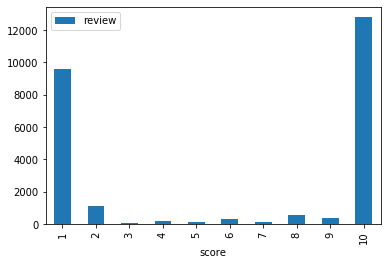

In [77]:
%matplotlib inline
D.groupby("score").count().plot.bar()

> 예상대로 리뷰가 1 아니면 10으로 양 극단으로 나뉘어진다.

# 감성분석 - Supervised
#### 리뷰의 별점을 정답으로 삼는다.

In [74]:
negative = D[D["score"] == 1]["review"]
positive = D[D["score"] == 10]["review"]

In [75]:
from konlpy.tag import Okt
ma = Okt()
for _ in negative:
    print(ma.pos(_))
    break

C:\Users\JINHYO\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


[('감성', 'Noun'), ('팔이', 'Noun'), ('좌파', 'Noun'), ('조센징', 'Noun'), ('들', 'Suffix'), ('수준', 'Noun'), ('에', 'Josa'), ('딱', 'Adverb'), ('맞는', 'Verb'), ('영화', 'Noun'), ('나라', 'Suffix'), ('꼬', 'Noun'), ('라지', 'Josa'), ('잘', 'Verb'), ('돌아간다', 'Verb'), ('.', 'Punctuation'), ('결혼', 'Noun'), ('하지마', 'Verb'), ('이', 'Determiner'), ('년', 'Noun'), ('들', 'Suffix'), ('아', 'Josa')]


In [76]:
ma.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

> subjectivity를 띄는 형용사를 우선적으로 사용하려고 했으나, 리뷰에서 형용사가 별로 없다...  
어쩔수 없이 objectivity를 띄는 명사를 사용하기로 한다.


In [80]:
# ma.nouns는 명사만 토크나이징해준다.

ma.nouns("안녕 내 이름은 코난, 탐정이지")

['안녕', '내', '이름', '코난', '탐정']

In [83]:
from collections import defaultdict
ma = Okt()
negativeTDM = defaultdict(list)
positiveTDM = defaultdict(list)
for i, _ in zip(negative.index, negative):
    for t in ma.nouns(_):
        negativeTDM[t].append(i)
for i, _ in zip(positive.index, positive):
    for t in ma.nouns(_):
        positiveTDM[t].append(i)

In [84]:
len(negativeTDM), len(positiveTDM)

(7322, 5974)

In [90]:
from collections import Counter
negativeTerms = Counter()
for t, df in negativeTDM.items():
    negativeTerms[t] = len(set(df))
    

positiveTerms = Counter()
for t, df in positiveTDM.items():
    positiveTerms[t] = len(set(df))

In [95]:
print("negative,        ", "positive")
list(zip(negativeTerms.most_common(20), 
         positiveTerms.most_common(20)))

negative,         positive


[(('영화', 3168), ('영화', 6435)),
 (('여자', 819), ('공감', 2386)),
 (('공감', 719), ('이야기', 1780)),
 (('페미', 709), ('엄마', 1650)),
 (('이', 585), ('생각', 1475)),
 (('점', 562), ('현실', 1341)),
 (('김지영', 516), ('이', 1302)),
 (('남자', 499), ('사람', 1275)),
 (('돈', 480), ('우리', 1187)),
 (('평점', 428), ('여자', 1144)),
 (('왜', 379), ('보고', 1131)),
 (('진짜', 376), ('눈물', 1125)),
 (('것', 359), ('김지영', 1049)),
 (('사람', 355), ('여성', 1036)),
 (('그', 353), ('정말', 1033)),
 (('여성', 352), ('것', 1019)),
 (('세대', 348), ('남자', 1007)),
 (('말', 338), ('모두', 1007)),
 (('쓰레기', 337), ('더', 992)),
 (('거', 335), ('꼭', 912))]

In [112]:
from math import log

V = list(set(list(positiveTerms.keys()) + 
             list(negativeTerms.keys())))
N = negative.count() + positive.count()
PMI = defaultdict(lambda: defaultdict(int))
for x in V:
    P_x = len(set(negativeTDM[x] + positiveTDM[x])) / N
    P_neg = negative.count() / N
    P_x_neg = len(set(negativeTDM[x])) / N
    P_pos = positive.count() / N
    P_x_pos = len(set(positiveTDM[x])) / N
    
    PMI_N = P_x_neg / (P_x * P_neg)
    PMI_P = P_x_pos / (P_x * P_pos)
    
    PMI[x]["N"] = log(PMI_N) if PMI_N != 0 else 0
    PMI[x]["P"] = log(PMI_P) if PMI_P != 0 else 0

In [113]:
# 긍정 단어 상위 20개

sorted(list(map(lambda x:(x, PMI[x]["P"]), PMI)),
       key=lambda r:r[1], reverse=True)[:20]

[('봐줫으', 0.5586781413594593),
 ('관내', 0.5586781413594593),
 ('점심시간', 0.5586781413594593),
 ('눌린거보', 0.5586781413594593),
 ('뿐더러', 0.5586781413594593),
 ('쫄', 0.5586781413594593),
 ('미국군', 0.5586781413594593),
 ('저떻', 0.5586781413594593),
 ('경하', 0.5586781413594593),
 ('비로소', 0.5586781413594593),
 ('종군기자', 0.5586781413594593),
 ('명성', 0.5586781413594593),
 ('공격성', 0.5586781413594593),
 ('반의', 0.5586781413594593),
 ('꼽는', 0.5586781413594593),
 ('바램', 0.5586781413594593),
 ('별별', 0.5586781413594593),
 ('몫임', 0.5586781413594593),
 ('린지', 0.5586781413594593),
 ('베베', 0.5586781413594593)]

In [114]:
# 부정 단어 상위 20개

sorted(list(map(lambda x:(x, PMI[x]["N"]), PMI)),
       key=lambda r:r[1], reverse=True)[:20]

[('사기', 0.8485494250061455),
 ('개꿀빨', 0.8485494250061455),
 ('메퇘지들', 0.8485494250061455),
 ('정신분열', 0.8485494250061455),
 ('우웩', 0.8485494250061455),
 ('사이코', 0.8485494250061455),
 ('테크', 0.8485494250061455),
 ('신조어', 0.8485494250061455),
 ('가산', 0.8485494250061455),
 ('배급사', 0.8485494250061455),
 ('킬로', 0.8485494250061455),
 ('한국판', 0.8485494250061455),
 ('강조', 0.8485494250061455),
 ('위안부', 0.8485494250061455),
 ('가든', 0.8485494250061455),
 ('화비', 0.8485494250061455),
 ('우욱', 0.8485494250061455),
 ('삼류', 0.8485494250061455),
 ('과학', 0.8485494250061455),
 ('메갈로돈', 0.8485494250061455)]

In [115]:
# SO, Semantic Orientation
SO = dict()
for x, pmi in PMI.items():
    SO[x] = pmi["P"] - pmi["N"]

In [116]:
sorted(SO.items(), key=lambda r:r[1], reverse=True)[:10]

[('리얼리즘', 4.092155351027195),
 ('여운', 3.907330664015122),
 ('김미경', 3.8690117997129856),
 ('펑펑', 3.846893994459366),
 ('남동생', 3.6419543490776394),
 ('훌쩍', 3.60194901446394),
 ('신랑', 3.5387701128424087),
 ('워킹맘', 3.4237007830576216),
 ('엉엉', 3.4237007830576216),
 ('간만', 3.39900817046725)]

In [125]:
sorted(SO.items(), key=lambda r:r[1], reverse=False)[:10]

[('코인', -4.63367670550037),
 ('광기', -4.538366525696045),
 ('노잼', -4.464258553542323),
 ('빠순이', -4.250684453244264),
 ('최악', -4.10601251737155),
 ('노답', -3.900789196290911),
 ('판타지영화', -3.8452193451361),
 ('피해망상증', -3.7556071864464124),
 ('쓰레기', -3.7120589412006777),
 ('남탓', -3.65716711363316)]

In [124]:
Q = "본 사람만 평점 달 수 있으면 좋겠네요. 남자를 조롱한 것도 아니고 여성의 삶에 대해 나타낸 영화인데, 왜 성별에 대한 비하와 악플을 다는지 모르겠네요~"
Q = '실제 1980년대생 여자란 10대 시절엔 아이돌을 쫓아다니며 온갖 패악질과 싸움질 그리고 엄청난 액수의 조공으로 부모 등골 뽑는 "빠순이"로, 20대 시절에는 남성에 기댄 헤픈 소비생활과 헛된 망상적 ...'
Sentiment = 0.0
for t in [_ for _ in ma.nouns(Q) if len(_) > 1]:
    if t in SO:
        Sentiment += SO[t]
        print(t, SO[t])
print()
print("Positive" if Sentiment > 0 else "Negative")
print(Sentiment)

실제 0.252993693863921
여자 0.04433080443998762
시절 0.43404755558001257
아이돌 -3.152072164576155
온갖 -2.369312825326522
악질 -2.7747779334346863
액수 -0.8485494250061453
조공 -0.8485494250061453
부모 -0.1501093412715276
등골 -0.8485494250061455
빠순이 -4.250684453244264
시절 0.43404755558001257
남성 0.8087410050214233
헤픈 -0.8485494250061453
소비 -1.388483572314796
생활 0.6264194482274686
헛된 -0.8485494250061453
망상 -3.213032864365842

Negative
-18.940640216851698


---

# 감성분석 - Semi-Supervised
#### score 없이 진짜 PMI만 가지고 감성분석해본다.

In [144]:
# seed를 어떤걸 고르느냐에 따라서 전체 성능이 갈린다.
positiveSeeds = ["엄마", "눈물", "이야기"]
negativeSeeds = ["최악", "쓰레기", "페미"]
TDM = defaultdict(list)
for i, d in zip(D.index, D["review"]):
    for t in [_ for _ in ma.nouns(d) if len(_) > 1]: # 정규화 - 1음절 이상만 
        TDM[t].append(i)

In [145]:
len(TDM)

9950

In [146]:
N = D["review"].count()
PMI = defaultdict(lambda: {"P":0.0, "N":0.0})
for x, df in TDM.items():
    P_x = len(set(df)) / N
    for seed in positiveSeeds:
        P_seed = len(set(TDM[seed])) / N
        P_x_seed = len(set(df).intersection(set(TDM[seed]))) \
                    / N
        PMI[x]["P"] += P_x_seed / (P_x * P_seed)
        
    for seed in negativeSeeds:
        P_seed = len(set(TDM[seed])) / N
        P_x_seed = len(set(df).intersection(set(TDM[seed]))) \
                    / N
        PMI[x]["N"] += P_x_seed / (P_x * P_seed)

In [147]:
sorted(list(map(lambda x:(x, PMI[x]["P"]), PMI)),
       key=lambda r:r[1], reverse=True)[:20]
# sorted(list(map(lambda x:(x, PMI[x]["N"]), PMI)),
#        key=lambda r:r[1], reverse=True)[:20]

[('피폐', 44.47448590180669),
 ('숨막', 44.47448590180669),
 ('뻑뻑', 44.47448590180669),
 ('민하', 44.47448590180669),
 ('정적', 33.95168211047789),
 ('더보', 32.95603487674974),
 ('최상급', 32.95603487674974),
 ('나영', 32.95603487674974),
 ('안산', 32.95603487674974),
 ('막내딸', 32.95603487674974),
 ('흘렷다', 32.95603487674974),
 ('주르르', 32.95603487674974),
 ('맺혔습니', 32.95603487674974),
 ('때부타', 32.95603487674974),
 ('형부', 32.95603487674974),
 ('영화에서처럼', 32.95603487674974),
 ('딸편', 32.95603487674974),
 ('식물성', 32.95603487674974),
 ('생후', 32.95603487674974),
 ('잠도', 32.95603487674974)]

In [148]:
SO = dict()
for x, pmi in PMI.items():
    SO[x] = pmi["P"] - pmi["N"]

In [151]:
Q = "본 사람만 평점 달 수 있으면 좋겠네요. 남자를 조롱한 것도 아니고 여성의 삶에 대해 나타낸 영화인데, 왜 성별에 대한 비하와 악플을 다는지 모르겠네요~"
# Q = '실제 1980년대생 여자란 10대 시절엔 아이돌을 쫓아다니며 온갖 패악질과 싸움질 그리고 엄청난 액수의 조공으로 부모 등골 뽑는 "빠순이"로, 20대 시절에는 남성에 기댄 헤픈 소비생활과 헛된 망상적 ...'
Sentiment = 0.0
for t in [_ for _ in ma.nouns(Q) if len(_) > 1]:
    if t in SO:
        Sentiment += SO[t]
        print(t, SO[t])
print()
print("Positive" if Sentiment > 0 else "Negative")
print(Sentiment)

사람 2.0580998848195717
평점 -0.9901379232659311
남자 -0.34798082120055707
조롱 0.3546257122571246
여성 2.3772454404432324
대해 3.8505873889423996
영화 -1.0880562168501777
성별 0.29257472487688885
대한 4.267690042776484
악플 0.7311885397025288

Positive
11.505836772501564
